In [195]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
sns.set()

from collections import Counter
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

# set display option

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

### Boosting

`Boosting is an` **ensemble learning technique** `that combines multiple weak learners (typically decision trees) to form a strong learner.`

✅ **Core Idea:** <br>
`Boosting builds models sequentially, with each new model focusing on the mistakes of the previous ones.` **The goal is to convert weak learners (models that do just slightly better than random) into a strong ensemble**.

🧠 **Analogy:** <br>
`Imagine you're trying to learn a difficult subject. The first teacher gives you a basic understanding. You don't fully grasp everything, so a second teacher steps in and helps clarify the parts you misunderstood. Then a third teacher continues correcting your misunderstandings, and so on.`

`By the end, all the “teachers” (weak learners) together help you truly understand the topic (a strong model).`

### Adaptive Boosting (AdaBoost)

`Adaboost is an ensemble learning method that combines multiple weak learners to form a strong classifer. It adapts by focusing more on misclassified data points in the previous iteration. It adapts weights based on incorrectly classified observations in the previous iterations.`

**What is AdaBoost?** <br>
`AdaBoost (Adaptive Boosting) is like having a team of weak students who individually aren't great at a subject, but when they work together strategically, they become incredibly smart as a group.`

**The Core Idea** <br>
`Imagine you're trying to classify emails as spam or not spam. Instead of using one complex algorithm, AdaBoost:` <br>
`Uses many simple "weak learners" (like decision stumps - trees with just one split)` <br>
`Trains them one by one` <br>
`Each new learner focuses on fixing the mistakes of the previous ones` <br>
`Combines all their predictions with a weighted vote`

**Why Adaptive** <br>
`Because the algorithm adapts the weights of training example based on error`

#### Step-by-Step Process

**Step 1: Start with Equal Weights**

`Give each training example the same importance weight` <br>
`If you have 100 emails, each gets weight = 1/100` <br>

`Say their are independent feature X = [1,2,3,4] and target y = [1,1,-1,-1]` <br>
`Therefore, total samples n = 4` <br>
`As we assign equal weight to each training example. Therefore, w_i = 1/n = 1/4 = 0.25` <br>
`So, the initial weight vector w = [0.25, 0.25, 0.25, 0.25]` <br>
`This means:` <br>
> * `Every data point has equal importance.` <br>
> * `Total weight = 1`

`We need weights because future steps will focus more on misclassified example. These weights act like attention score that guide the learning.`

In [142]:
# Create data

X = [1,2,3,4]
y = [1,1,-1,-1]

In [143]:
# Initilize weight

def initial_weights(len_data):
    return len_data*[1/len_data]

weights = initial_weights(len(X))
weights

[0.25, 0.25, 0.25, 0.25]

In [144]:
# 

df = pd.DataFrame({'X': X, 'y': y, 'w': weights})
df

,X,y,w
0,1,1,0.25
1,2,1,0.25
2,3,-1,0.25
3,4,-1,0.25


**Step 2: Train First Weak Learner**

`Train a simple classifier (like "if word 'free' appears → spam")` <br>
`This classifier will make some mistakes` <br>

`Say we are finding decision stump with threshold say left (X <= 2.5) and right (X > 2.5). The total possible splits are [1.5, 2.5, 3.5] but for this example we are trying only 2.5 otherwise we must do splits on each of the splitters.` <br>
`So, for each possible split, the algorithm computes the weighted classification error and selects the split which gives most homogenous seperation.`

In [145]:
# try splitting at x <= 2.5
# group_A = [1,2] --> pred = 1 
# group_B = [3,4] --> pred = -1
# Create a column in df which consist of predictions based on the split

def data_split(data, feature, threshold):
    '''
    
    '''
    pred = []
    for i in data[feature]:
        if i <= threshold:
            pred.append(1)
        else:
            pred.append(-1)
            
    data['pred'] = pred
    data['error'] = abs(data['y'] - data['pred'])
    return data

data_split(df, 'X', 2.5)

,X,y,w,pred,error
0,1,1,0.25,1,0
1,2,1,0.25,1,0
2,3,-1,0.25,-1,0
3,4,-1,0.25,-1,0


**Step 3: Update Weights Based on Mistakes**

`Examples that were classified WRONG get higher weights` <br>
`Examples that were classified RIGHT get lower weights` <br>
`This forces the next classifier to pay more attention to the hard cases`

`We calculate weighted error (epsilon). We calculate how wrong the weak learner was (not just by how many samples it misclassified) by how important those sample were using the formula:`
> **j = sum(weights x 1[h(x) != y])**
>> `h(x) is pred`

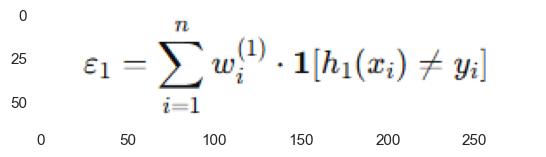

In [146]:
plt.imshow(img.imread('ada_weighted_error.png'))
plt.grid()
plt.show();

**What is epsilon in above**

`Total weight of misclassified samples by first weak learner h_1(x).`

`It is not just count of mistakes, but it is the sum of weights of mistakes. Why?`
> * `How bad the learner was.` <br>
> * `How much trust it deserves.`

In [147]:
# 

def weighted_error(data, y, pred, weight):
    '''
    Input: 
    Output: 
    '''
    ww = []
    for i,j,k in zip(data[pred], data[weight], data[y]):
        ww.append(j * (1*(i != k)))
    return sum(ww)

weighted_error(df, 'y', 'pred', 'w')

0.0

* `As the error is zero (0) means the learner is perfect.` <br>
* `What if learner is not perfect? What does the error value indicates?`
> * `If the error < 0.5 --> A learner is good we can use it. (As error goes close to zero it become more trustworthy)` <br>
> * `If the error > 0.5 --> A learner is Worse that random guesses.` <br>
> * `If the error = 0.5 --> The learner is random.`

In [148]:
# For self understanding of the concept

(True != True) * 1, (True != False) * 1

(0, 1)

**Step 4: Train Next Weak Learner (Compute learners weight that is confidence) --> Alpha**

`Train another simple classifier on the reweighted data.` <br>
`It will focus more on the examples the previous classifier got wrong.` <br>
`Basically, we ask question,` **`"How much should we trust this weak learner".`**

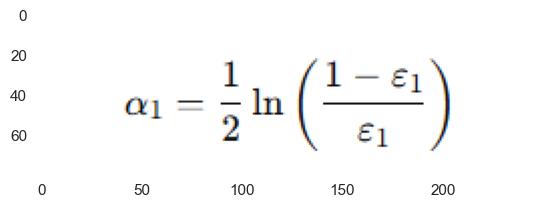

In [149]:
plt.imshow(img.imread('learners_weight_confidence_formula.png'))
plt.grid()
plt.show();

**Breakdown of the formula**

`In step 3, we calculated the weighted error of the weak learner.` <br>
`Now, in step 4, we will` **transform the error rate** `of the learner` **into a confidence score.**

#### Example Scenarios

> **Case 1** : `Perfect learner (Epsilon = 0)` <br>
>> * `It is 100% correct.`

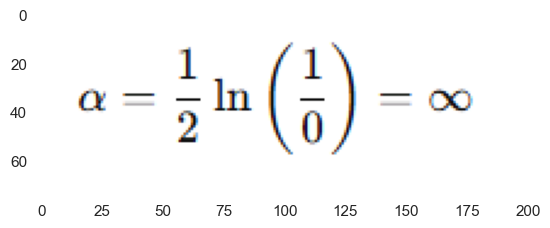

In [150]:
plt.imshow(img.imread('case_1.png'))
plt.grid()
plt.show();

### _In practice, we avoid division by zero by adding tiny delta value with epsilon_

> **Case 2** : `Error(Epsilon) = 0.5`

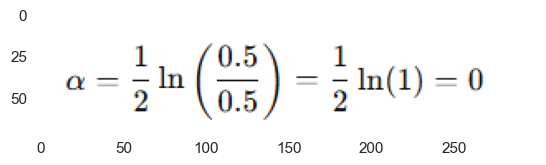

In [151]:
plt.imshow(img.imread('case_2.png'))
plt.grid()
plt.show();

`Zero weight means it is random guessing. This weak learner will be ignored.`

> **Case 3** : `Error(Epsilon) > 0.5`

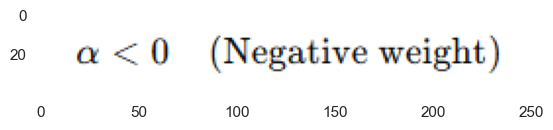

In [152]:
plt.imshow(img.imread('case_3.png'))
plt.grid()
plt.show();

`This means the learner is worse than random. So, we will flip its predictions by giving it negative trust.`

> **Case 4** : `Realistic Good Learner (say epsilon = 0.2)`

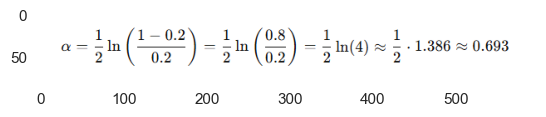

In [153]:
plt.imshow(img.imread('realistic_case.png'))
plt.grid()
plt.show();

`This alpha value is decent and acceptable.`

**Why this formula**
> **1. Log-odds** <br>
>> `It is essentially the log odds of success versus failure.`

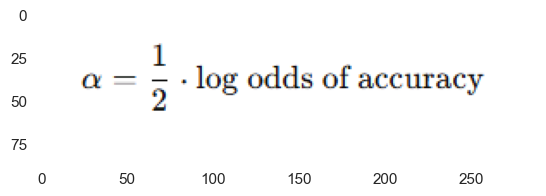

In [154]:
plt.imshow(img.imread('learners_weight_confidence_formula_1.png'))
plt.grid()
plt.show();

| Role            | ε    | Problem                            | α    | Why Better                     |
| --------------- | ---- | ---------------------------------- | ---- | ------------------------------ |
| Just error rate | 0.10 | Good learner, but how much better? | 1.10 | Converts it to a voting weight |
| Just error rate | 0.49 | Barely better than guessing        | 0.02 | Very weak say in final vote    |
| Just error rate | 0.00 | Perfect — but how confident?       | ∞    | Mathematically amplified trust |
| Just error rate | 0.50 | Random guesser                     | 0    | Automatically muted            |

### Step 5: Updating sample weights based on mistakes

**Goal of this step**
> `1. Teach the next weak learner to focus more on the mistake of the previous learner.`
>> **How?**
>>> `By increasing the weight of misclassified sample and decreasing weights for correct ones.`

`Keep adding weak learners, each focusing on previous mistakes. Usually do this 50-200 times`

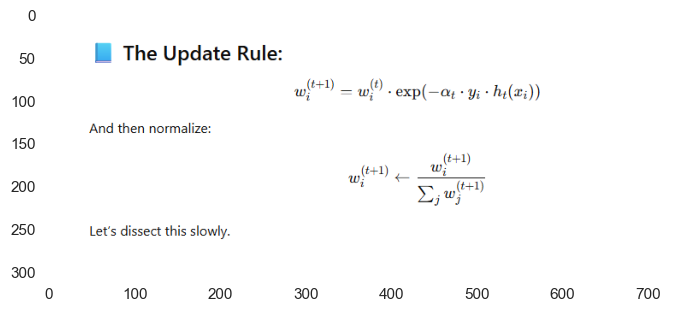

In [155]:
plt.figure(figsize= (8,8))
plt.imshow(img.imread('update_rule.png'))
plt.grid()
plt.show();

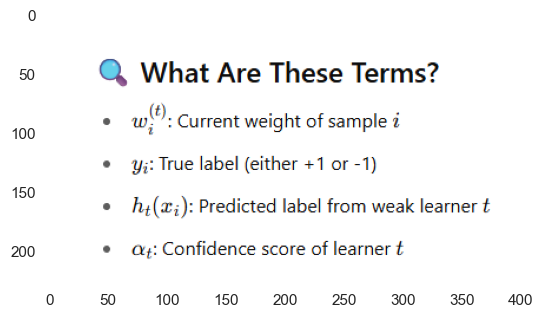

In [156]:
plt.imshow(img.imread('update_rule1.png'))
plt.grid()
plt.show();

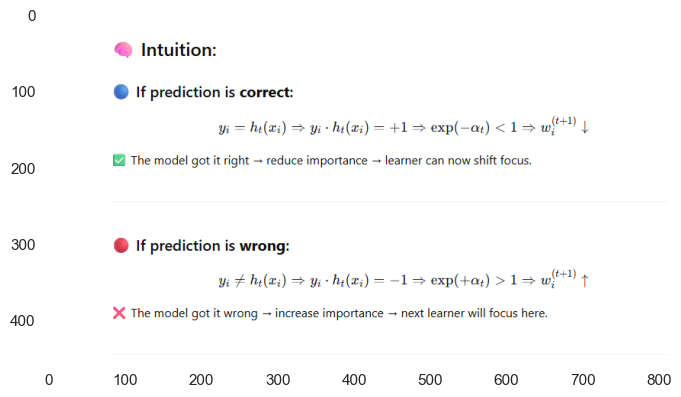

In [157]:
plt.figure(figsize= (8,8))
plt.imshow(img.imread('update_rule2.png'))
plt.grid()
plt.show();

In [158]:
'''
Consider:
initial_weight_ith_observation = 0.2 (As total no. of observation = 5) 
epsilon = 0.2 (As the prediction only 1 observation was inccorect)
Therefore,
alpha = 0.693

Calculate:
Weight of the ith observation for the next iteration (next tree)
'''
# Compare the updated weights of correctly predicted observations and incorrectly predicted observation
print(f"Updated weight of correctly predicted observation:{np.exp(-0.693)*0.2},\
        \nUpdated weight of incorrectly predicted observation:{np.exp(0.693)*0.2}")

Updated weight of correctly predicted observation:0.10001471913915355,        
Updated weight of incorrectly predicted observation:0.3999411321082328


`We can clearly see if the observation was correctly predicted, the weight is decreasing for the next tree and vice versa.`

### Why exponential (why not just add or substract)

`Because exponential weighting give:`
> * `Soft/Small penalty for small error.` <br>
> * `Heavy penalty for big error/confidence.`

In [159]:
# Checking if updated weights sum is equal to summation of previous tree weights
# It is not necessarly that they will come equal

print(f"Initial tree weighted weights:{0.2*5}\
       \nUpdated tree weights:{(0.10001471913915355*4)+0.3999411321082328}")

Initial tree weighted weights:1.0       
Updated tree weights:0.800000008664847


In [160]:
# Normalize weights
# Normalize updated weights sum will equal to 1

updated_weights = [0.10001471913915355, 0.10001471913915355, 0.10001471913915355, 0.10001471913915355, 0.3999411321082328]
def normalize_updated_weights(updated_weights):
    return [i/sum(updated_weights) for i in updated_weights]

norm_updated_weights = normalize_updated_weights(updated_weights)
print(f"Normalize updated weights:{norm_updated_weights}")
sum(norm_updated_weights)

Normalize updated weights:[0.12501839756986033, 0.12501839756986033, 0.12501839756986033, 0.12501839756986033, 0.4999264097205587]


1.0

### Why normalize?

`To ensure the weights still form a probability distribution i.e, they sum to 1. That keeps the future learner consistant.`

**Step 6: Combine Predictions (Weighted majority voting)**

**Goal of the step**

`Combine all weak learners to make one strong final prediction using a weighted vote, where stronger learner have more say.`

`Better performing classifiers get more "voting power"` <br>
`Final prediction = weighted majority vote of all weak learners`

`Each one (weak learner) give its opinion but not all the opinion are equal.`

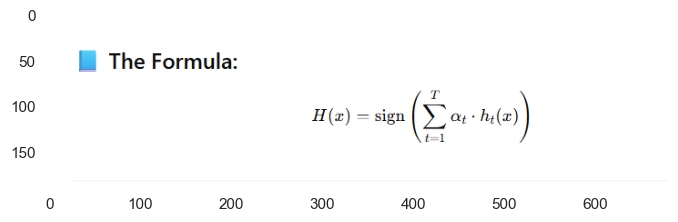

In [161]:
plt.figure(figsize= (8,8))
plt.imshow(img.imread('weighted_majority_voting.png'))
plt.grid()
plt.show();

#### What is happening here

**what is h_t(x) -->**
> * `It is the prediction from the t-th weak learner/tree.` <br>
> * `It gives the output either 1 or -1.`

**what is alpha_t -->**
> * `It tells about how strongly that learner opinion matter.`
>> * `Bigger the alpha, more confidence.` <br>
>> * `Smaller the alpha, less confidence.` <br>
>> * `Very low or even 0 alpha value means the learner is random.`

**what is alpha_t x h_t(x) -->**
> * `This is a weighted vote.`

`Suppose, we create two stumps [1,2], their predictions h_t(x) = [1, -1], alpha_t = [0.55, 0.8] and vote alpha_t*h_t(x) = [0.55, -0.8]` <br> `Therefore, the final result = 0.55+(-0.8) = -0.25. As the result is negative, the final prediction will be -1.`

In [162]:
# create data

f1 = [1,2,3,4]
y = [1,-1,1,-1]

df = pd.DataFrame({'f1': f1, 'y': y})
df

,f1,y
0,1,1
1,2,-1
2,3,1
3,4,-1


In [163]:
# Weight initilization

w = initial_weights(len(df))
w

[0.25, 0.25, 0.25, 0.25]

In [164]:
# add in data

df['w'] = w
df

,f1,y,w
0,1,1,0.25
1,2,-1,0.25
2,3,1,0.25
3,4,-1,0.25


In [165]:
def data_split(data, feature, threshold):
    '''
    
    '''
    for t in threshold:
        pred = []
        for i in data[feature]:
            if i <= t:
                pred.append(1)
            else:
                pred.append(-1)       
        data['pred_' + str(t)] = pred
        e = [1 if i != j else 0 for i, j in zip(data['pred_' + str(t)], data['y'])]
        data['error_' + str(t)] = e
    
    return data

data_split(df,'f1', [1.5,2.5,3.5])

,f1,y,w,pred_1.5,error_1.5,pred_2.5,error_2.5,pred_3.5,error_3.5
0,1,1,0.25,1,0,1,0,1,0
1,2,-1,0.25,-1,0,1,1,1,1
2,3,1,0.25,-1,1,-1,1,1,0
3,4,-1,0.25,-1,0,-1,0,-1,0


In [166]:
# find weighted error/epsilon for each split

def weighted_error(data, col_nam):
    '''
    Input: 
    Output: 
    '''
    return sum(data[col_nam])/len(data)

for col_nam in ['error_1.5', 'error_2.5', 'error_3.5']:
    print(f"{col_nam}: {weighted_error(df, col_nam)}")

error_1.5: 0.25
error_2.5: 0.5
error_3.5: 0.25


`Both splits 1.5 and 3.5 are giving same weighted error so we can choose any of them randomly. Say, 3.5`

In [167]:
updated_df = df.drop(['pred_1.5', 'error_1.5', 'pred_2.5', 'error_2.5'], axis= 1)
updated_df

,f1,y,w,pred_3.5,error_3.5
0,1,1,0.25,1,0
1,2,-1,0.25,1,1
2,3,1,0.25,1,0
3,4,-1,0.25,-1,0


**According to data, x <= 3.5 --> 1 and x > -1**

In [168]:
# calculate alpha

w = weighted_error(df, 'error_3.5')

alpha = 0.5*np.log((1 - w)/w)
alpha

np.float64(0.5493061443340549)

In [169]:
# update_weights by updation rule

updated_wt = np.array(df['w']* np.exp(-alpha*df['y']*df['pred_3.5']))
updated_wt

array([0.14433757, 0.4330127 , 0.14433757, 0.14433757])

In [170]:
# normalise weight

nuw = updated_wt/sum(updated_wt)
nuw

array([0.16666667, 0.5       , 0.16666667, 0.16666667])

In [171]:
sum(nuw)

np.float64(1.0)

#### Iteration/Tree/Round 2

In [172]:
df1 = df[['f1', 'y']]
df1.loc[:, 'w'] = pd.Series(nuw)
df1

C:\Users\Atharv Soni\AppData\Local\Temp\ipykernel_17344\3732623494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'w'] = pd.Series(nuw)


,f1,y,w
0,1,1,0.166667
1,2,-1,0.500000
2,3,1,0.166667
3,4,-1,0.166667


**Simple Example** <br>
Let's say you're classifying fruits as apple or orange:

**Round 1:** <br>
**Weak learner 1:** "If red → apple" (gets 70% accuracy) <br>
Mistakes: Red oranges classified as apples <br>
Increase weight of red oranges for next round

**Round 2:**  <br>
**Weak learner 2:** "If round → orange" (focuses on fixing red orange mistakes) <br>
Now red oranges are more likely classified correctly

**Final prediction:**

New fruit is red and round <br>
Learner 1 says: Apple (with confidence 0.7) <br>
Learner 2 says: Orange (with confidence 0.6) <br>

Combined: Weighted vote determines final answer <br>

**Why It Works** <br>
**Focuses on Hard Cases:** Each new classifier specializes in examples that previous ones found difficult <br>
**Reduces Bias:** Combines many simple rules to create complex decision boundaries <br>
**Reduces Variance:** Averaging many weak learners reduces overfitting <br>
**Adaptive:** The "Ada" in AdaBoost means it adapts the training process based on previous mistakes <br>

**Key Advantages** <br>
Turns weak learners into strong ones <br>
Generally doesn't overfit easily <br>
Works well with simple base classifiers <br>
Automatically focuses on difficult examples <br>

**Key Disadvantages** <br>
Sensitive to noise and outliers (keeps focusing on them) <br>
Can be slow to train <br>
Performance depends heavily on the weak learner choice <br>

**Real-World Analogy** <br>
Think of it like studying for an exam:

Take a practice test (first weak learner) <br>
Identify questions you got wrong <br>
Study those topics more intensively (increase their weight) <br>
Take another practice test focusing on your weak areas <br>
Repeat until you're strong in all areas <br>
Your final knowledge is the combination of all your focused study sessions <br>
The beauty of AdaBoost is that it automatically figures out what the "hard questions" are and keeps focusing on them until the overall performance improves dramatically.

In [179]:
# read data

data = pd.read_csv('..\..\data\mnist_train.csv')
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,

In [180]:
# data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [181]:
# null values

[i for i in (data.isnull().sum() > 0) if i == True]

[]

In [182]:
# constant features

constant_features = [i for i in data.columns if data[i].nunique() == 1]
constant_features

['1x1',
 '1x2',
 '1x3',
 '1x4',
 '1x5',
 '1x6',
 '1x7',
 '1x8',
 '1x9',
 '1x10',
 '1x11',
 '1x12',
 '1x17',
 '1x18',
 '1x19',
 '1x20',
 '1x21',
 '1x22',
 '1x23',
 '1x24',
 '1x25',
 '1x26',
 '1x27',
 '1x28',
 '2x1',
 '2x2',
 '2x3',
 '2x4',
 '2x25',
 '2x26',
 '2x27',
 '2x28',
 '3x1',
 '3x2',
 '3x27',
 '3x28',
 '4x1',
 '4x2',
 '4x28',
 '5x1',
 '6x1',
 '6x2',
 '7x1',
 '18x1',
 '21x1',
 '24x1',
 '24x2',
 '24x28',
 '25x1',
 '25x2',
 '25x28',
 '26x1',
 '26x2',
 '26x28',
 '27x1',
 '27x2',
 '27x3',
 '27x27',
 '27x28',
 '28x1',
 '28x2',
 '28x3',
 '28x4',
 '28x25',
 '28x26',
 '28x27',
 '28x28']

In [183]:
# Drop constant Features

data.drop(constant_features, axis= 1, inplace= True)

Text(0, 0.5, 'Count')

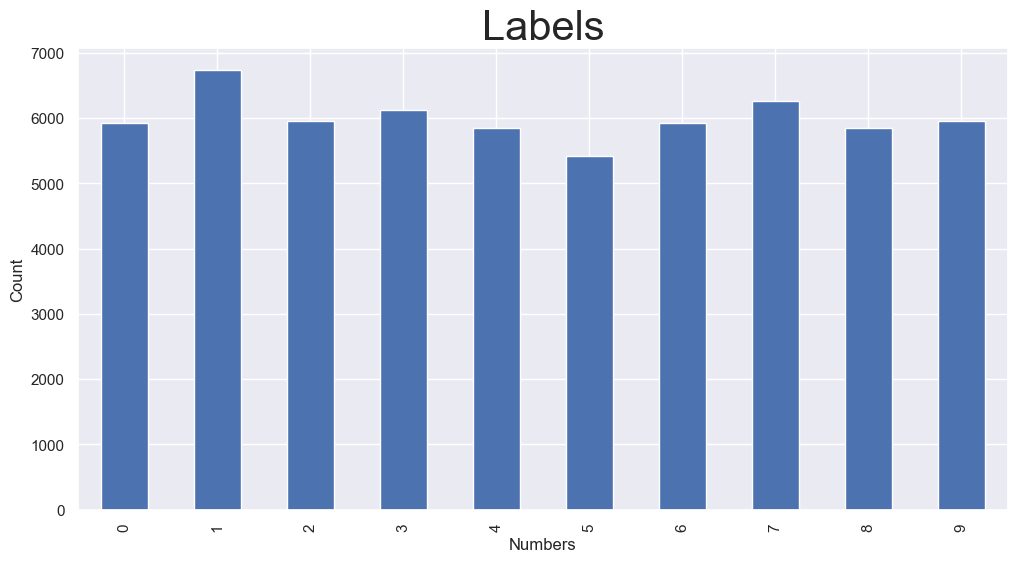

In [184]:
# label value counts

plt.figure(figsize= (12,6))
data['label'].value_counts().sort_index().plot(kind= 'bar')
plt.title('Labels', fontsize= 30)
plt.xlabel('Numbers')
plt.ylabel('Count')

In [185]:
# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis= 1),
                                                   data['label'],
                                                   test_size= 0.2,
                                                   random_state= 0)

X_train.shape, X_test.shape

((48000, 717), (12000, 717))

In [186]:
# target value counts

y_train.value_counts()

label
1    5363
7    5037
3    4923
2    4792
9    4744
6    4728
0    4718
4    4689
8    4660
5    4346
Name: count, dtype: int64

In [187]:
ada = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth= 2), # Stump
                         n_estimators= 10,
                         learning_rate= 0.1)

ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=10)

In [188]:
ada.predict(X_test)

array([3, 6, 7, ..., 3, 1, 6], shape=(12000,))

In [189]:
confusion_matrix(y_test, ada.predict(X_test))

array([[ 930,    5,    6,   36,    1,   30,   25,   42,  128,    2],
       [   1, 1228,    4,   12,    4,    1,   38,   85,    0,    6],
       [  65,  188,  559,   29,   10,    0,   78,  108,  127,    2],
       [  27,  117,   15,  739,   14,   20,   25,  115,   90,   46],
       [   3,    6,   17,    8,  807,    0,   44,  215,   21,   32],
       [ 107,   31,    6,  326,   66,  136,   67,  194,   99,   43],
       [  55,   70,  142,   19,  206,    1,  594,   59,   40,    4],
       [  13,   28,    4,    3,   26,    0,   29, 1096,   10,   19],
       [   1,  184,   21,   58,   35,   14,   27,  115,  719,   17],
       [   9,    9,   10,   18,   87,    2,   37,  766,   19,  248]])

In [190]:
accuracy_score(y_test, ada.predict(X_test))

0.588

In [191]:
class AdaBoost:
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n  # initialize sample weights

        for t in range(self.n_estimators):
            # Train weak learner
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(X, y, sample_weight=w)
            pred = clf.predict(X)

            # Calculate error
            err = np.sum(w * (pred != y)) / np.sum(w)

            # Avoid divide-by-zero
            if err == 0:
                alpha = 1
            else:
                alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

            # Save model and alpha
            self.models.append(clf)
            self.alphas.append(alpha)

            # Update weights
            w *= np.exp(-alpha * y * pred)
            w /= np.sum(w)  # normalize

    def predict(self, X):
        # Weighted majority vote
        final = sum(alpha * clf.predict(X) for clf, alpha in zip(self.models, self.alphas))
        return np.sign(final)

In [192]:
X, y = make_classification(n_samples=200, n_features=5, random_state=0)
y = 2 * y - 1  # convert to -1, +1 for AdaBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ab = AdaBoost(n_estimators=10)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Code from scratch

In [193]:
class DecisionStump:
    """
    A single-level decision tree that handles:
    - Numerical features (using threshold splits)
    - Categorical features (using equality splits)
    """
    def __init__(self):
        self.feature_index = None
        self.threshold = None         # For numeric split
        self.category = None          # For categorical split
        self.is_categorical = False
        self.polarity = 1             # 1 or -1, determines which side is -1
        self.alpha = None             # Learner's weight

    def predict(self, X):
        """
        Predicts labels (+1 or -1) based on learned feature and threshold/category

        Parameters:
        X: np.array of shape (n_samples, n_features)

        Returns:
        np.array of shape (n_samples,) with values +1 or -1
        """
        n_samples = X.shape[0] # no. of observations
        predictions = np.ones(n_samples) # initialization
        feature_values = X[:, self.feature_index] 

        if self.is_categorical:
            if self.polarity == 1:
                predictions[feature_values == self.category] = -1
            else:
                predictions[feature_values != self.category] = -1
        else:
            if self.polarity == 1:
                predictions[feature_values <= self.threshold] = -1
            else:
                predictions[feature_values > self.threshold] = -1

            # Apply polarity to comparison
            # if self.polarity == 1:
            #     predictions[feature_values < self.threshold] = -1
            # else:
            #     predictions[feature_values > self.threshold] = -1
                
        return predictions


class AdaBoostClassifier:
    """
    AdaBoost classifier combining multiple decision stumps
    Handles categorical, numerical, and missing values
    """
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.stumps = []
        self.alphas = []

    def _is_categorical(self, feature_col):
        """
        Check if a feature column is categorical based on dtype or cardinality
        """
        return not np.issubdtype(feature_col.dtype, np.number)

    def fit(self, X, y):
        """
        Trains AdaBoost on input data X and binary targets y (-1, +1)
        """
        n_samples, n_features = X.shape
        w = np.full(n_samples, 1 / n_samples)  # Step 1: equal weights

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            min_error = float('inf') # Initilization

            # Try all features
            for feature_i in range(n_features):
                feature_values = X[:, feature_i] # Filter data for each feature

                # Skip feature if too many missing values
                # Only check NaNs if the data type is numeric
                if np.issubdtype(feature_values.dtype, np.number):
                    if np.isnan(feature_values).mean() > 0.5:
                        continue


                is_cat = self._is_categorical(feature_values)
                stump.is_categorical = is_cat # updating the value

                # Handle missing values safely for both numeric and categorical
                if np.issubdtype(feature_values.dtype, np.number):
                    clean_values = feature_values[~np.isnan(feature_values)] # selecting not nan values
                else:
                    clean_values = feature_values[feature_values != None] # selecting not none values

                thresholds = np.unique(clean_values)


                for threshold in thresholds:
                    for polarity in [1, -1]:  # Try both directions
                        predictions = np.ones(n_samples)
                        '''
                        If thresholds = [A,B,C]
                        then,
                        for polarity = 1
                        for threshold = A, predictions = [1,1,1]
                        for threshold = B, predictions = [-1,1,1]
                        for threshold = C, predictions = [-1,-1,1]
                        for polarity = -1
                        for threshold = A, predictions = [1,-1,-1]
                        for threshold = B, predictions = [1,1,-1]
                        for threshold = C, predictions = [1,1,1]
                        '''
                        if polarity == 1:
                            predictions[feature_values < threshold] = -1
                        else:
                            predictions[feature_values > threshold] = -1

                        # Step 3: compute weighted error
                        error = np.sum(w[y != predictions])

                        if error < min_error:
                            min_error = error
                            stump.feature_index = feature_i
                            stump.polarity = polarity
                            if is_cat:
                                stump.category = threshold
                                stump.threshold = None
                            else:
                                stump.threshold = threshold
                                stump.category = None
                            best_preds = predictions.copy()

            # Step 4: compute alpha
            epsilon = 1e-10 # a very small value
            stump.alpha = 0.5 * np.log((1 - min_error + epsilon) / (min_error + epsilon))

            # Step 5: update weights
            w *= np.exp(-stump.alpha * y * best_preds)
            w /= np.sum(w)  # normalize

            self.stumps.append(stump)
            self.alphas.append(stump.alpha)

    def predict(self, X):
        """
        Makes final prediction using weighted voting of all stumps

        Parameters:
        X: np.array of shape (n_samples, n_features)

        Returns:
        np.array of predictions: +1 or -1
        """
        n_samples = X.shape[0]
        final = np.zeros(n_samples)
        for stump, alpha in zip(self.stumps, self.alphas):
            pred = stump.predict(X)
            final += alpha * pred
        return np.sign(final)  # +1 or -1

In [194]:
# Example Data (XOR-like pattern)
X =  np.array([['A', 'B', 'A', 'A', 'B'],
               [1, 2, 3, 4, 5]]).T
y = np.array([+1, -1, +1, -1, -1])

# Train
model = AdaBoostClassifier(n_estimators=3)
model.fit(X, y)

# Predict
print("Predictions:", model.predict(X))

Predictions: [ 1. -1.  1. -1. -1.]


### Comparing adaboost with decision tree and random forest

In [197]:
# load iris data

X, y = load_iris(return_X_y= True, as_frame= True)
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [198]:
y

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     1
51     1
52     1
53     1
54     1
55     1
56     1
57     1
58     1
59     1
60     1
61     1
62     1
63     1
64     1
65     1
66     1
67     1
68     1
69     1
70     1
71     1
72     1
73     1
74     1
75     1
76     1
77     1
78     1
79     1
80     1
81     1
82     1
83     1
84     1
85     1
86     1
87     1
88     1
89     1
90     1
91     1
92     1
93     1
94     1
95     1
96     1
97     1
98     1
99     1
100    2
101    2
102    2
103    2
104    2
105    2
106    2
107    2
108    2
109    2
110    2
1

In [200]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 9)
X_train.shape, X_test.shape

((112, 4), (38, 4))

In [201]:
# create instance

dt = DecisionTreeClassifier()
dt

DecisionTreeClassifier()

In [202]:
# learn data

dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [204]:
dt.score(X_train, y_train)

1.0

In [205]:
dt.score(X_test, y_test)

0.9736842105263158

In [206]:
# create instance

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf

RandomForestClassifier()

In [207]:
# learn data

rf.fit(X_train, y_train)

RandomForestClassifier()

In [208]:
rf.score(X_train, y_train)

1.0

In [209]:
rf.score(X_test, y_test)

0.9736842105263158

In [210]:
# create instance

ab = AdaBoostClassifier()
ab

AdaBoostClassifier()

In [211]:
# Learn the values

ab.fit(X_train, y_train)

AdaBoostClassifier()

In [212]:
ab.score(X_train, y_train)

1.0

In [213]:
ab.score(X_test, y_test)

1.0